<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Увоз библиотека</h2>
</div>

In [23]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Учитавање података и модела</h2>
</div>

In [25]:
def set_seeds(seed: int=42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [26]:
# Setup directory paths to train and test images
train_dir = 'EPT100/train_512'
val_dir = 'EPT100/val_512'
test_dir = 'EPT100/test_512'

In [27]:
train_data = datasets.ImageFolder(train_dir)
train_data

Dataset ImageFolder
    Number of datapoints: 8603
    Root location: EPT100/train_512

In [28]:
# 1. Get pretrained weights for Swin base
pretrained_swin_weights = torchvision.models.Swin_B_Weights.DEFAULT

# 2. Setup a Swin model instance with pretrained weights
pretrained_swin = torchvision.models.swin_b(weights=pretrained_swin_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_swin.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = train_data.classes
set_seeds(33)
pretrained_swin.head = nn.Linear(in_features=1024, out_features=len(class_names)).to(device)

In [29]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_swin, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
SwinTransformer (SwinTransformer)                       [32, 3, 224, 224]    [32, 100]            --                   Partial
├─Sequential (features)                                 [32, 3, 224, 224]    [32, 7, 7, 1024]     --                   False
│    └─Sequential (0)                                   [32, 3, 224, 224]    [32, 56, 56, 128]    --                   False
│    │    └─Conv2d (0)                                  [32, 3, 224, 224]    [32, 128, 56, 56]    (6,272)              False
│    │    └─Permute (1)                                 [32, 128, 56, 56]    [32, 56, 56, 128]    --                   --
│    │    └─LayerNorm (2)                               [32, 56, 56, 128]    [32, 56, 56, 128]    (256)                False
│    └─Sequential (1)                                   [32, 56, 56, 128]    [32, 56, 56, 128]    --                   Fal

In [30]:
# Get automatic transforms from pretrained Swin weights
pretrained_swin_transforms = pretrained_swin_weights.transforms()
print(pretrained_swin_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[238]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [31]:
import os

NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir: str, test_dir: str, val_dir: str, transform: transforms.Compose, batch_size: int, num_workers: int=NUM_WORKERS):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)
  val_data = datasets.ImageFolder(val_dir, transform = transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
    
  val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )
    
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, val_dataloader, test_dataloader, class_names

In [32]:
# Setup dataloaders
train_dataloader_pretrained, val_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     val_dir=val_dir,
                                                                                                     transform=pretrained_swin_transforms,
                                                                                                     batch_size=32)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001331117B700>
Traceback (most recent call last):
  File "D:\miniconda_instalacija\envs\master_rad\lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "D:\miniconda_instalacija\envs\master_rad\lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Тренирање модела</h2>
</div>

In [33]:
from going_modular.going_modular import engine
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_swin.parameters(), 
                             lr=3e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained Swin feature extractor model
set_seeds(33)
pretrained_swin_results, model = engine.train(model=pretrained_swin,
                                      train_dataloader=train_dataloader_pretrained,
                                      val_dataloader=val_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=100,
                                      patience=15,
                                      lr_patience=12,
                                      best_model_path='Results/Models/Swin_Base_Transfer_Learning_100ep_15es_12lrp.pth',
                                      device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5857 | train_acc: 0.6482 | val_loss: 0.7041 | val_acc: 0.8374 | learning_rate: 0.003000
Epoch: 2 | train_loss: 0.6068 | train_acc: 0.8523 | val_loss: 0.4483 | val_acc: 0.8871 | learning_rate: 0.003000
Epoch: 3 | train_loss: 0.4057 | train_acc: 0.9009 | val_loss: 0.3575 | val_acc: 0.9115 | learning_rate: 0.003000
Epoch: 4 | train_loss: 0.3178 | train_acc: 0.9256 | val_loss: 0.3006 | val_acc: 0.9182 | learning_rate: 0.003000
Epoch: 5 | train_loss: 0.2529 | train_acc: 0.9390 | val_loss: 0.2528 | val_acc: 0.9357 | learning_rate: 0.003000
Epoch: 6 | train_loss: 0.2247 | train_acc: 0.9426 | val_loss: 0.2511 | val_acc: 0.9265 | learning_rate: 0.003000
Epoch: 7 | train_loss: 0.1917 | train_acc: 0.9539 | val_loss: 0.2073 | val_acc: 0.9449 | learning_rate: 0.003000
Epoch: 8 | train_loss: 0.1800 | train_acc: 0.9521 | val_loss: 0.2041 | val_acc: 0.9416 | learning_rate: 0.003000
Epoch: 9 | train_loss: 0.1585 | train_acc: 0.9594 | val_loss: 0.1831 | val_acc: 0.9502 | learnin

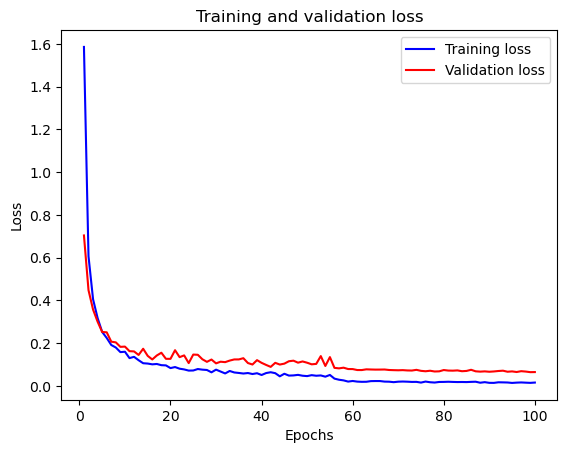

In [34]:
epochs = range(1, len(pretrained_swin_results['train_loss']) + 1)

plt.plot(epochs, pretrained_swin_results['train_loss'], 'b-', label='Training loss')
plt.plot(epochs, pretrained_swin_results['val_loss'], 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

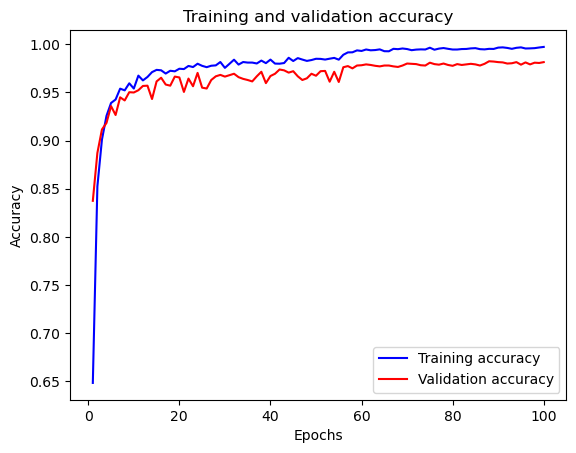

In [35]:
epochs = range(1, len(pretrained_swin_results['train_acc']) + 1)

plt.plot(epochs, pretrained_swin_results['train_acc'], 'b-', label='Training accuracy')
plt.plot(epochs, pretrained_swin_results['val_acc'], 'r-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
loaded_model = torch.load('Results/Models/Swin_Base_Transfer_Learning_100ep_15es_12lrp.pth')

# Switch the model to evaluation mode
loaded_model.eval()

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=128, out_features=384, bias=True)
          (proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=512, out_features=128, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px; text-align: center;">

<h2 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Comic Sans MS">
Тестирање модела</h2>
</div>

In [37]:
set_seeds(33)
test_loss, test_acc = engine.test(model=loaded_model,
                           test_dataloader=test_dataloader_pretrained,
                           loss_fn=loss_fn,
                           device=device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0724, Test Accuracy: 0.9814


In [38]:
import pickle

# Save the pretrained_vit_results dictionary to disk
with open('Results/Training results/pretrained_swin_base_100ep_results.pkl', 'wb') as f:
    pickle.dump(pretrained_swin_results, f)

In [39]:
with open('Results/Training results/pretrained_swin_base_100ep_results.pkl', 'rb') as f:
    loaded_pretrained_swin_results = pickle.load(f)